# Code to identify mis-classified points and explore their features

July 21, 2020


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import subprocess as sp
import pickle
import ipywidgets as widgets
import time


In [2]:
from sklearn.metrics import roc_curve

In [3]:
%matplotlib widget

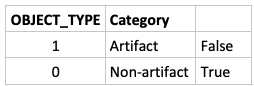

## Read test data and predictions

In [4]:
main_dir='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/final_summary_data_folder/'

In [5]:
f1=main_dir+'sample_test_data/full_test_data/input_labels_y.txt'
f2=main_dir+'results_inference/y_fulltest_pred.txt'

In [6]:
df=pd.DataFrame()
df['label']=np.loadtxt(f1,dtype=np.int16)
df['pred']=np.loadtxt(f2,dtype=np.float32)

print(df.shape)
df.head()


(40000, 2)


,label,pred
0,0,0.000139
1,0,0.000028
2,0,0.496657
3,1,0.999948
4,1,0.999581


## Histograms

In [7]:
df.plot(kind='hist',y=['label','pred'],subplots=True,grid=True,bins=12)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

In [9]:
### Prediction histograms
#### Comparing predction

plt.figure()
column='pred'
# Predictions at points where label is 1
sig_preds=df[df.label==1][column].values
# Predictions at points where label is 0
bkg_preds=df[df.label==0][column].values
plt.hist([sig_preds,bkg_preds],bins=20,alpha=0.5,label=[column+':Artifact=1',column+':non-artifacts=0'])
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot roc curve

####The ROC curve flip argument

Since True=1 in keras, but Non-Artifact is defined as 0 in the paper, 
Tp <-> Tn and Fn <-> Fp

Actual roc curve is x=mdr, y=fpr


mdr=Fn/(Tp+Fn) -> Fp/(Tn+Fp) = fpr \

fpr=Fp/(Tn+Fp) -> Fn/(Tp+Fn) = mdr = fnr = 1-tpr


Hence we get an mdr <-> fpr flip


In [10]:
def f_roc(df,col,label,fig_type='mdr'):
    '''
    Function to plot the roc curve
    '''
    fpr,tpr,threshold=roc_curve(df.label,df[col],pos_label=None)
    
    if fig_type=='mdr':
#         x,y=1-tpr,fpr 
        x,y=fpr,(1-tpr)     # The roc curve flip: mdr-> fpr; fpr-> (1-tpr)
        plt.plot(x, y,linestyle='',label=label,markersize=4,marker='*')
        # ### Reference points in mdr plot in paper
        
    
        rf_2015_lst=[(0.03,0.038),(0.04,0.024),(0.05,0.016)]
        for count,a in enumerate(rf_2015_lst):
            if count==0:
                plt.plot(a[0],a[1],marker='s',markersize=8,color='k',label='RF_2015')
            else: 
                plt.plot(a[0],a[1],marker='s',markersize=8,color='k')

        plt.xlabel('MDR')
        plt.ylabel('FPR')
        plt.xlim(0,0.1)
        plt.ylim(0,0.05)
        
    if fig_type=='tpr':
        x,y=(1-tpr),(1-fpr)     # The roc curve flip: fpr-> (1-tpr); tpr-> (1-fpr)
        plt.plot(x, y,linestyle='',label=label,markersize=4,marker='*')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    
    plt.legend()
    

In [11]:
plt.figure()
f_roc(df,'pred','pred',fig_type='mdr')
plt.title('MDR roc curve')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'MDR roc curve')

In [12]:

plt.figure()
f_roc(df,'pred','pred',fig_type='tpr')
# plt.xscale('log')
plt.xlim(0,1)
plt.title('TPR roc curve')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'TPR roc curve')

### Threshold prediction

In [32]:
fpr,tpr,threshold=roc_curve(df.label,df['pred'],pos_label=None)

cols=['threshold','fpr','tpr','mdr']
df_roc=pd.DataFrame(columns=cols)
# for i,j in zip(['threshold','fpr','tpr','mdr'],[threshold,fpr,tpr,1-tpr]):  ### the method for normal signal-background
for i,j in zip(['threshold','fpr','tpr','mdr'],[threshold,1-tpr,1-fpr,fpr]): # the method for our case: Artifact is 0
    df_roc[i]=j


In [36]:
df_roc

,threshold,fpr,tpr,mdr
0,2.000000e+00,1.000000,1.000000,0.000000
1,1.000000e+00,0.997195,1.000000,0.000000
2,9.999999e-01,0.996343,1.000000,0.000000
3,9.999999e-01,0.992937,1.000000,0.000000
4,9.999998e-01,0.991585,1.000000,0.000000
...,...,...,...,...
8818,1.490116e-06,0.000000,0.000599,0.999401
8819,1.430511e-06,0.000000,0.000399,0.999601
8820,1.251698e-06,0.000000,0.000299,0.999701
8821,9.238720e-07,0.000000,0.000100,0.999900


In [37]:
df_roc[1:].plot(kind='line',y=['threshold','fpr','tpr'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [38]:
df_roc[1:].plot(kind='line',x='threshold',y=['fpr','tpr','mdr'],style='*')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='threshold'>

In [47]:
def f_get_threshold(df_roc,value,metric='fpr'):
    
    assert metric in ['fpr','tpr','mdr'], "metric not any of fpr,tpr, mdr"

    if metric=='fpr':
        df=df_roc[df_roc[metric]<value].sort_values(by=metric,ascending=False)
        print("For %s < %s, threshold < %s "%(metric,value,df.loc[df[metric].idxmax()].threshold))

    if metric=='mdr':
        df=df_roc[df_roc[metric]<value].sort_values(by=metric,ascending=False)
        print("For %s < %s, threshold > %s "%(metric,value,df.loc[df[metric].idxmax()].threshold))

    if metric=='tpr':
        df=df_roc[df_roc[metric]>value].sort_values(by=metric,ascending=True)
        print("For %s > %s, threshold > %s "%(metric,value,df.loc[df[metric].idxmin()].threshold))

#     print(df.loc[df[metric].idxmax()].threshold)

    display(df)
    return df

print("Threshold definition: Value > threshold is defined as 1, which is False (Non-artifact)")
f_get_threshold(df_roc,0.01,'fpr')
f_get_threshold(df_roc,0.02,'mdr')
# f_get_threshold(df_roc,0.99,'tpr')

Threshold definition: Value > threshold is defined as 1, which is False (Non-artifact)
For fpr < 0.01, threshold < 0.3177732229232788 


,threshold,fpr,tpr,mdr
4124,3.177732e-01,0.009968,0.977041,0.022959
4125,3.165433e-01,0.009968,0.976942,0.023058
4126,3.158555e-01,0.009918,0.976942,0.023058
4127,3.156214e-01,0.009918,0.976892,0.023108
4128,3.153765e-01,0.009868,0.976892,0.023108
...,...,...,...,...
6107,1.893342e-04,0.000000,0.402176,0.597824
6108,1.892149e-04,0.000000,0.401976,0.598024
6109,1.891851e-04,0.000000,0.401927,0.598073
6110,1.891255e-04,0.000000,0.401777,0.598223


For mdr < 0.02, threshold > 0.3853110671043396 


,threshold,fpr,tpr,mdr
4073,0.385311,0.012072,0.980136,0.019864
4072,0.385487,0.012172,0.980136,0.019864
4071,0.388076,0.012172,0.980285,0.019715
4070,0.388691,0.012222,0.980285,0.019715
4069,0.389375,0.012222,0.980435,0.019565
...,...,...,...,...
1363,0.999881,0.662242,1.000000,0.000000
1364,0.999881,0.662042,1.000000,0.000000
1365,0.999881,0.661992,1.000000,0.000000
1366,0.999880,0.661891,1.000000,0.000000


,threshold,fpr,tpr,mdr
4073,0.385311,0.012072,0.980136,0.019864
4072,0.385487,0.012172,0.980136,0.019864
4071,0.388076,0.012172,0.980285,0.019715
4070,0.388691,0.012222,0.980285,0.019715
4069,0.389375,0.012222,0.980435,0.019565
...,...,...,...,...
1363,0.999881,0.662242,1.000000,0.000000
1364,0.999881,0.662042,1.000000,0.000000
1365,0.999881,0.661992,1.000000,0.000000
1366,0.999880,0.661891,1.000000,0.000000


In [48]:
# f_get_threshold(df_roc,0.01,'fpr')
f_get_threshold(df_roc,0.02,'mdr').head(1)
# f_get_threshold(df_roc,0.99,'tpr')

For mdr < 0.02, threshold > 0.3853110671043396 


,threshold,fpr,tpr,mdr
4073,0.385311,0.012072,0.980136,0.019864
4072,0.385487,0.012172,0.980136,0.019864
4071,0.388076,0.012172,0.980285,0.019715
4070,0.388691,0.012222,0.980285,0.019715
4069,0.389375,0.012222,0.980435,0.019565
...,...,...,...,...
1363,0.999881,0.662242,1.000000,0.000000
1364,0.999881,0.662042,1.000000,0.000000
1365,0.999881,0.661992,1.000000,0.000000
1366,0.999880,0.661891,1.000000,0.000000


,threshold,fpr,tpr,mdr
4073,0.385311,0.012072,0.980136,0.019864


In [35]:
# fname='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/input_npy_files/full_x.npy'
# a1=np.load(fname)
# fname='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/input_npy_files/full_y.npy'
# a2=np.load(fname)

# data_size=a1.shape[0]
# print(data_size)
# idxs=np.random.randint(0,data_size,size=40000)

In [46]:
# print(a1[idxs].shape,a2[idxs].shape)
# main_dir='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/final_summary_data_folder/sample_test_data/full_test_data/'
# np.save(main_dir+'input_x.npy',a1[idxs])
# np.savetxt(main_dir+'input_labels_y.txt',a2[idxs])

In [45]:
# np.load(main_dir+'input_x.npy')